# Reading basic QR code with a CNN

In this notebook, we will take a predefined network called the ResNet-18, and train it on QR codes and the text that it encodes.

The QR code will be an image of 29 x 29 x 1, and will be generated by encoding random characters that are up to 10 characters long. We will not be using LSTMs or other RNNs, but instead give 10 predictions on what the character will be on each place.

In [1]:
import torch
import torch.optim as optim
from torch import nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import os
import random
import qrcode

# Prepairing the model

We will be using the ResNet-18 model, but will change the input so it takes in images with single channels, and change the output to (batch, word length, possible characters).

In [2]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        import torchvision.models as models
        self.model = models.resnet18()
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.avgpool = nn.Flatten()        
        self.model.fc = nn.Linear(512, word_length * len(chars))
    def forward(self, x):
        x = self.model(x)
        x = x.view(-1,word_length,len(chars))
        return x

# Define utility functions

In [3]:
qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=1,
    border=4,
)
# Generate a 29x29x1 QR code from given data
def generate(data):
    qr.clear()
    qr.add_data(data)
    code = qr.make_image(fill_color="black", back_color="white")
    return np.reshape(np.array(code,dtype=np.float32),(1,29,29))

# Convert string into vectors with corresponding tokens
def words_to_vec(words):
    vectors=[]
    
    for word in words:
        vectors.append([chars.index(word[i]) if i < len(word) else len(chars)-1 for i in range(word_length)])

    return torch.tensor(vectors)

# Convert one hot encoded vector into string
def vec_to_words(vectors):
    words=''
    
    for i in vectors:
            i = i.argmax()
            if i==len(chars)-1:
                break
            words+=chars[i]
            
    return words

# Generate random string with size 1 to word_length
def randword():
    return ''.join([random.choice(chars) for i in range(random.randint(1,word_length))])

# Generate n number of random strings and QR code pair
def sample(n):
    if isinstance(n,int):
        words = [randword() for i in range(n)]
    else:
        words = n
    x = torch.tensor([generate(word) for word in words])
    y = words_to_vec(words)

    return x,y

# Generate the QR code given a word, give it to the network, and give back what it thinks the word was
def test(word):
  model.eval() 

  word = torch.Tensor([generate(word)]).to(device)
  word = model(word)[0]

  model.train()

  return vec_to_words(word)

def plot(*data):
    plt.clf()
    ax = plt.gca()
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.yaxis.grid(True)
    
    for i in data:
        plt.plot(i)
    
    plt.legend(['Loss'], loc='lower left')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
  

# Set up model and optimizer

Since the default PyTorch doesn't have a function to do batched cross entropy, we make the function ourselves.

In [4]:
batch_size = 100
word_length = 10
chars='abcdefghijklmnopqrstuvwxyz '

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model=Model().to(device)


def criterion(x,y):
  return torch.stack([nn.functional.cross_entropy(x[:,i],y[:,i]) for i in range(word_length)]).mean()

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

# Train loop

In PyTorch, the basic train loop consists of 


1.   Loading training data
2.   Initilize gradients for the model
3.   Forward pass until the loss
4.   Backpropagate the loss
5.   Do the optimization step


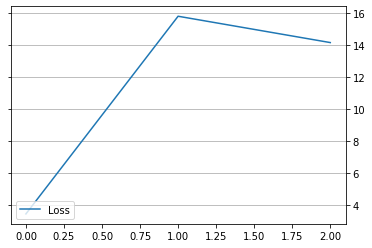

accuracy:vgmgs


In [ ]:
losses = []
for epoch in range(10000):
        x,y = sample(batch_size)

        optimizer.zero_grad()
        predict = model(x)
        loss = criterion(predict,y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        plot(losses)
        
        print(f'accuracy:{test("hello")}')